<h1 align = 'center'>Comparing market capindex vs GDP weighted index</h1>

| Name | SNR |
|-|-|
| Max Siers |  2060383|
| Gert Vandeveire | 2069464 |

<h2> Abstract </h2>

lorem ipsum

<h2> Research question </h2>
lorem ipsum

<h2> Motivation </h2>
https://www.morganstanley.com/im/en-us/institutional-investor/insights/articles/emerging-market-allocations-how-much-to-own.html

<h2> Methodology </h2>
blabla

<h2> Conclusion </h2>
blabla

<h2>Install and import packages</h2>

The raw data and python code can be found in this [github map](https://github.com/GJWVandeveire/AEA).

In [1]:
#For this project install the following packages:
#pip install statsmodels
#pip install pmdarima
#pip install openpyxl

In [2]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import date, timedelta

<h2>Import and clean data</h2>
<h4>MSCI ACWI data</h4>
The first dataset contains the MSCI All Country World Index. We use this to compare volatility and returns between market cap weighted funds and GDP-weighted funds, along with more detailed data imported below. We also use this data to estimate a short period price prediction with an ARIMA-model and volatility prediction with a GARCH-model. <br><br>

*This dataset was imported from ???*

In [3]:
#read data
df = pd.read_excel('EersteData.xlsx')

df.head(14)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,Start Date,2000-12-29 00:00:00,NaN,NaN
8,NaN,NaN,NaN,End Date,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,MSCI AC World Index EUR Net,MSCI ACWI GDP Net Local,FTSE ALL WORLD


The raw data contains some redundant colums and rows. Therefore, we reorganize the dataset by slicing, renaming the colums, adding missing values and resetting the index.

In [4]:
#dropping columns and rows
df.drop(df.columns[:3], axis=1, inplace=True)
df.drop(df.index[:13], axis=0, inplace=True)

In [5]:
#add column names
df.columns = ['Date', 'MSCI ACWI', 'MSCI ACWI GDP Price', 'FTSE ALL WORLD']

In [6]:
#making sure python recognizes date as date type (time series for ARIMA-model)
df['Date'] = pd.to_datetime(df['Date'])

#checking type
type(df['Date'])

pandas.core.series.Series

In [7]:
#add first date to make continuous (for ARIMA model): 3 days because it is before the weekend
df.iloc[0,0] = df.iloc[1,0] - timedelta(days=3)

In [8]:
#add first cell for MSCI ACWI GDP manually because not in data
df.iloc[0, 2] = 877.689

In [9]:
#reset index after slicing
df.reset_index(drop=True, inplace=True)
df.head()

,Date,MSCI ACWI,MSCI ACWI GDP Price,FTSE ALL WORLD
0,2000-12-29,100,877.689,NaN
1,2001-01-01,99.995,877.613,NaN
2,2001-01-02,97.602,866.1976,NaN
3,2001-01-03,99.782,879.6873,NaN
4,2001-01-04,100.061,885.8732,NaN


In our new dataset, 'FTSE ALL WORLD' seems to have a number of missing values. This is not an issue, as we will not be using this index. However, the market cap weighted price 'MSCI ACWI' seems to be set to 100 at the first value, while the GDP weighted is not. We use the percentage change and a for loop to **create a new column 'MSCI ACWI GDP'** that is also set to 100 at the first value.

In [10]:
#MSCI GDP percentage change
df['PercentageChange'] = df['MSCI ACWI GDP Price'].pct_change() +1
df.loc[0, 'PercentageChange'] = 1

#create new column for MSCI GDP
df['MSCI ACWI GDP'] = np.nan
df.loc[0, 'MSCI ACWI GDP'] = 100

In [11]:
#apply formula
for i in range(1, len(df)):
    df.loc[i, 'MSCI ACWI GDP'] = df.loc[i-1, 'MSCI ACWI GDP'] * df.loc[i, 'PercentageChange']
    
df.tail()

,Date,MSCI ACWI,MSCI ACWI GDP Price,FTSE ALL WORLD,PercentageChange,MSCI ACWI GDP
5488,2022-01-12,319.385,3476.26,4969.86,1.010732,396.069678
5489,2022-01-13,315.364,3452.36,4909.83,0.993125,393.346618
5490,2022-01-14,315.151,3437.43,4906.25,0.995675,391.645560
5491,2022-01-17,316.176,3439.67,4922.19,1.000652,391.900776
5492,2022-01-18,316.176,3439.67,4922.19,1.000000,391.900776


To **plot** a comparison between market cap - and GDP-weighted prices, we isolate the relevant colums and set the index to 'Date'.

In [12]:
#isolating relevant indices
df2 = df.loc[:,['Date', 'MSCI ACWI', 'MSCI ACWI GDP']]

<AxesSubplot:xlabel='Date'>

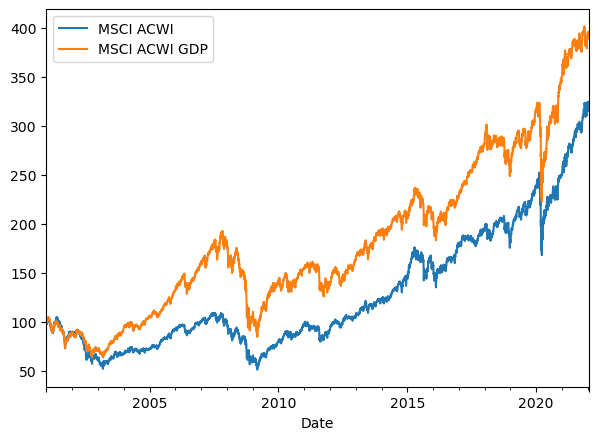

In [13]:
#customize fig size
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

#plotting function
df2.set_index('Date', inplace=True)
df2.plot()

Populating the interactive namespace from numpy and matplotlib


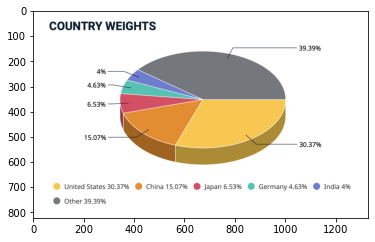

In [105]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('MSCIGDP.png')
imgplot = plt.imshow(img)
plt.show()

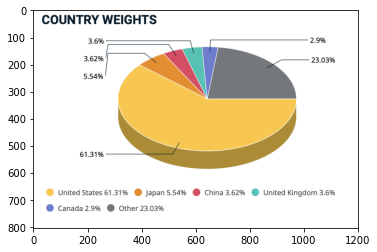

In [106]:
img2 = mpimg.imread('MSCICAP.png')
imgplot = plt.imshow(img2)
plt.show()

<h4> MCSI West, MSCI EM, MSCI EMU</h4>
The second dataset further breaks down the MSCI index into MSCI World index (which consists of the developed markets and will from now on be referenced to as 'West'), MSCI Emerging Markets index and MSCI Economic and Monetary union of the European union. We use this data to more profoundly analyze volatility and returns.<br><br>


*The second imported data is from ???*

In [14]:
#read data
df3 = pd.read_excel('Data_extra fondsen.xlsx')

df3.head(10)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Start Date,1998-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN
2,NaN,End Date,2021-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,MSCI World,MSCI World GDP,MSCI EM,MSCI EM GDP,MSCI EMU,MSCI EMU GDP
6,NaN,NaN,MSDEWIN Index,MSDEWILN Index,MSDEEEMN Index,M1EFGW Index,MSDEEMUN Index,M1EMGW Index
7,NaN,NaN,Last Price,Last Price,Last Price,Last Price,Last Price,Last Price
8,NaN,Dates,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST,PX_LAST
9,NaN,1998-12-31 00:00:00,100,NaN,NaN,NaN,100,NaN


Again, there are a couple of missing values. Looking at the dataset, we see that World (= West), EMU and EMU GDP values start at index 32. EM starts at 532, EM GDP at 402 and World GDP (= West GDP) at 2296. On top of that, our data only gives weekly prices for West GDP in the first years that is was reported. Therefore, we decided to drop West and West GDP from our dataset. For all other indices, we clean the data as we did before. This time, we make sure the data starts when the last index starts (EM = 532).

In [15]:
#drop unnecessary blanks
df3.drop(df3.columns[:1], axis=1, inplace=True)
df3.drop(df3.index[:530], axis=0, inplace=True)

In [16]:
#add column names
df3.columns = ['Date', 'West', 'West GDP', 'EM', 'EM GDP', 'EMU', 'EMU GDP']

In [17]:
# drop MSCI West + MSCI West GDP
df3.drop(df3.columns[1:3], axis=1, inplace=True)

In [18]:
#reset index after slicing
df3.reset_index(drop=True, inplace=True)
df3.head()

,Date,EM,EM GDP,EMU,EMU GDP
0,2000-12-29 00:00:00,100,809.16328,135.589,114.56637
1,2001-01-01 00:00:00,99.902,808.73795,135.589,114.56637
2,2001-01-02 00:00:00,99.109,802.98478,135.589,113.26443
3,2001-01-03 00:00:00,99.93,807.42825,135.589,112.71302
4,2001-01-04 00:00:00,103.553,833.89068,135.589,113.72818


Again, we see that the prices are not starting at 100, except for EM. We use the same technique as we used for ACWI for all the other columns. The new columns containing 'MSCI' in the name are used in further analysis.

In [19]:
#resetting to starting value 100 with same formula as used before
#MSCI EM
df3['PctEM'] = df3['EM'].pct_change() +1
df3.loc[0, 'PctEM'] = 1
df3['MSCI EM'] = np.nan
df3.loc[0, 'MSCI EM'] = 100

#MSCI EM GDP
df3['PctEM GDP'] = df3['EM GDP'].pct_change() +1
df3.loc[0, 'PctEM GDP'] = 1
df3['MSCI EM GDP'] = np.nan
df3.loc[0, 'MSCI EM GDP'] = 100

#MSCI EMU
df3['PctEMU'] = df3['EMU'].pct_change() +1
df3.loc[0, 'PctEMU'] = 1
df3['MSCI EMU'] = np.nan
df3.loc[0, 'MSCI EMU'] = 100

#MSCI EMU GDP
df3['PctEMU GDP'] = df3['EMU GDP'].pct_change() +1
df3.loc[0, 'PctEMU GDP'] = 1
df3['MSCI EMU GDP'] = np.nan
df3.loc[0, 'MSCI EMU GDP'] = 100

In [20]:
#creating new columns based on starting values 100  
#MSCI EM
for i in range(1, len(df3)):
    df3.loc[i, 'MSCI EM'] = df3.loc[i-1, 'MSCI EM'] * df3.loc[i, 'PctEM']
    
#MSCI EM GDP
for i in range(1, len(df3)):
    df3.loc[i, 'MSCI EM GDP'] = df3.loc[i-1, 'MSCI EM GDP'] * df3.loc[i, 'PctEM GDP']
    
#MSCI EMU
for i in range(1, len(df3)):
    df3.loc[i, 'MSCI EMU'] = df3.loc[i-1, 'MSCI EMU'] * df3.loc[i, 'PctEMU']
    
#MSCI EMU GDP
for i in range(1, len(df3)):
    df3.loc[i, 'MSCI EMU GDP'] = df3.loc[i-1, 'MSCI EMU GDP'] * df3.loc[i, 'PctEMU GDP']
    
df3.tail()

,Date,EM,EM GDP,EMU,EMU GDP,PctEM,MSCI EM,PctEM GDP,MSCI EM GDP,PctEMU,MSCI EMU,PctEMU GDP,MSCI EMU GDP
5476,2021-12-27 00:00:00,499.85,4971.3163,259.604,216.82705,1.001892,499.850,1.000559,614.377397,1.006822,191.463909,1.004222,189.258899
5477,2021-12-28 00:00:00,503.05,4984.9704,261.142,218.0267,1.006402,503.050,1.002747,616.064832,1.005924,192.598220,1.005533,190.306021
5478,2021-12-29 00:00:00,497.356,4927.8797,259.994,217.71035,0.988681,497.356,0.988547,609.009309,0.995604,191.751543,0.998549,190.029893
5479,2021-12-30 00:00:00,500.201,4963.2346,260.728,218.25895,1.005720,500.201,1.007174,613.378625,1.002823,192.292885,1.002520,190.508742
5480,2021-12-31 00:00:00,502.172,4974.5477,260.317,217.44247,1.003940,502.172,1.002279,614.776748,0.998424,191.989763,0.996259,189.796072


We isolate the relevant indices and set index to 'Date', to check if the plot shows any worrying trends.

In [21]:
#isolating relevant indices and setting index
df4 = df3.loc[:,['Date', 'MSCI EM', 'MSCI EM GDP', 'MSCI EMU', 'MSCI EMU GDP']]
df4.set_index('Date', inplace=True)

This dataset can now be merged with the previous one, in order to get one dataframe 'df'.

<AxesSubplot:xlabel='Date'>

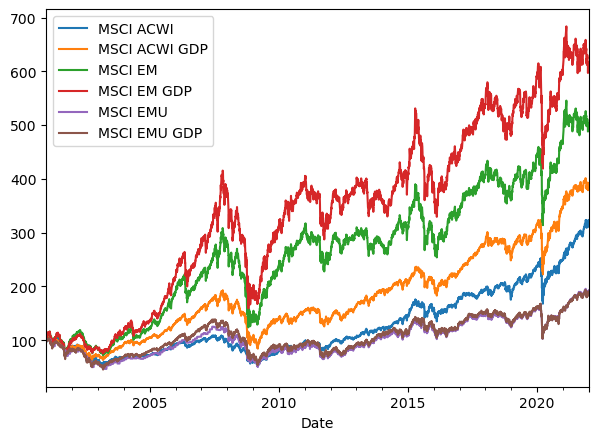

In [22]:
#merging with MSCI ACWI
df = pd.merge(df2, df4, on = 'Date')
df.plot()

Note that ACWI GDP performs better compared to ACWI. This can be explained by the high returns of EM to which ACWI GDP has a higher allocation compared to ACWI. On the other hand, ACWI GDP also has a larger share of EMU, which performs worse compared to ACWI, which might explain why ACWI GDP still performs relatively similar to ACWI. 

<h2>Historical Volatility and risk ratio's</h2>

In [23]:
returns = df.pct_change()*100
returns.head(800)

,MSCI ACWI,MSCI ACWI GDP,MSCI EM,MSCI EM GDP,MSCI EMU,MSCI EMU GDP
Date,,,,,,
2000-12-29,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01,-0.005000,-0.008659,-0.098000,-0.052564,0.0,0.000000
2001-01-02,-2.393120,-1.300733,-0.793778,-0.711376,0.0,-1.136407
2001-01-03,2.233561,1.557347,0.828381,0.553369,0.0,-0.486834
2001-01-04,0.279610,0.703193,3.625538,3.277372,0.0,0.900659
...,...,...,...,...,...,...
2004-01-16,1.958479,0.583506,1.796233,1.181457,0.0,0.945641
2004-01-19,0.293326,0.641435,0.941206,1.057995,0.0,0.447435
2004-01-20,-1.127280,0.158418,-0.553796,-0.308407,0.0,-0.867601


The returns for MSCI EMU indicate 0 very often. By taking a proper look at the dataset, we notice that before 2008, the values change only monthly. As a results, we drop MSCI EMU and MSCI EMU GDP from our dataset.

In [24]:
df.drop(df4.columns[2:4], axis=1, inplace=True)

In [25]:
# log returns
log_returns = np.log(df.astype(float)/df.shift(1).astype(float))

In [26]:
# standard deviation of returns
daily_std = log_returns.std()

<AxesSubplot:>

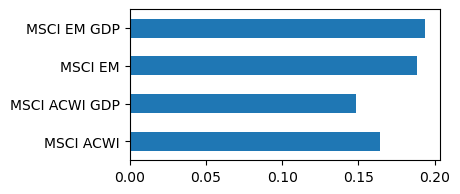

In [27]:
# volatility: trading days
annual_std = daily_std * np.sqrt(261)
plt.rcParams['figure.figsize'] = (4, 2)
annual_std.plot.barh()

We define the riskfree rate based on the one-month treasury bill rate.

In [107]:
# defining riskfree rate
rf = 0.0068/261

In [108]:
# sharpe ratio
def sharpe(returns, days = 261):
    volatility = returns.std() * np.sqrt(days)
    sharpe_ratio = (returns.mean() - rf) / volatility
    return sharpe_ratio

<AxesSubplot:>

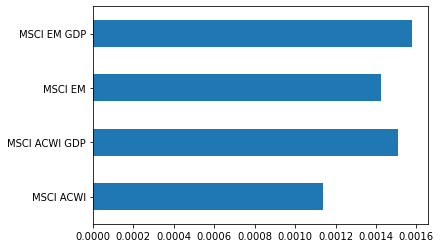

In [109]:
# horizontal bar plot
sharpe(log_returns).plot.barh()

In [110]:
# information ratio
def ir(returns, benchmark_returns, days = 261):
    return_difference = returns - benchmark_returns
    volatility = return_difference.std() * np.sqrt(days)
    information_ratio = return_difference.mean() / volatility
    return information_ratio

In [111]:
print(ir(log_returns['MSCI ACWI'], log_returns['MSCI ACWI GDP']))
print(ir(log_returns['MSCI EM'], log_returns['MSCI EM GDP']))

-0.00046890795155127957
-0.0006421822228305669


In [112]:
# modigliani ratio
def m2(returns, benchmark_returns, days = 261):
    volatility = returns.std() * np.sqrt(days)
    sharpe_ratio = (returns.mean() - rf) / volatility
    benchmark_volatility = benchmark_returns.std() * np.sqrt(days)
    m2_ratio = (sharpe_ratio * benchmark_volatility) + rf
    return m2_ratio

In [113]:
print(m2(log_returns['MSCI ACWI'], log_returns['MSCI ACWI GDP']))
print(m2(log_returns['MSCI EM'], log_returns['MSCI EM GDP']))

0.00019441467140676993
0.00030163601990031613


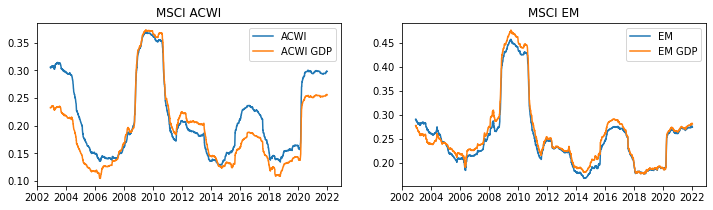

In [114]:
#trailing volatility over time (500 trading days)
trading_window = 500
volatility = log_returns.rolling(window = trading_window).std()*np.sqrt(trading_window)

# plot ACWI and EM trailing volatility
plt.rcParams['figure.figsize'] = (12, 3)

fig, axes = plt.subplots(1, 2)
axes[0].plot(volatility['MSCI ACWI'], label = 'ACWI'); axes[0].set_title('MSCI ACWI')
axes[0].plot(volatility['MSCI ACWI GDP'], label = 'ACWI GDP')
axes[0].legend()

axes[1].plot(volatility['MSCI EM'], label = 'EM'); axes[1].set_title('MSCI EM')
axes[1].plot(volatility['MSCI EM GDP'], label = 'EM GDP')
axes[1].legend()

plt.show()

In [115]:
# max drawdown
def max_drawdown(returns):
    cumulative_returns = (returns + 1).cumprod()
    peak = cumulative_returns.expanding(min_periods = 1).max()
    drawdown = (cumulative_returns / peak) - 1
    return drawdown.min()

max_drawdowns = log_returns.apply(max_drawdown, axis = 0)
max_drawdowns

MSCI ACWI       -0.574350
MSCI ACWI GDP   -0.586646
MSCI EM         -0.619754
MSCI EM GDP     -0.639707
dtype: float64

<AxesSubplot:>

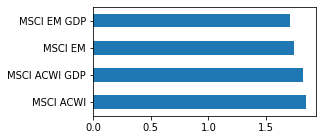

In [116]:
# calmar ratio
calmar = np.exp(log_returns.mean()*261)/abs(max_drawdowns)
plt.rcParams['figure.figsize'] = (4, 2)
calmar.plot.barh()

<H2>Predicting with ARIMA-model </h2>

*In order to prevent extensive coding retain clarity, we only use MSCI ACWI for our predictive models*

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

constant mean
constant variance
an autocovariance that does not depend on time.
There are 2 major reasons behind non-stationaruty of a TS:

Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

**ARIMA-model** is ...

$Y_t = \alpha + \beta_1Y_{t-1} + \beta_2Y_{t-2} + ... + \beta_pY_{t-p}\epsilon_t + \phi_1\epsilon_{t-1} + \phi_2\epsilon_{t-2} + ... + \phi_q\epsilon_{t-q}$

ARIMA model in words:

Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

<h3> ADF-test </h3>
check if time series is non-stationary with Augmented Dickey Fuller test
- H0: non-stat
- H1: stat

In [38]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy import log

In [39]:
#assign short names for ease of use
cap = df['MSCI ACWI']
gdp = df['MSCI ACWI GDP']

In [40]:
#ADF test
ADF_cap = adfuller(cap.dropna())
ADF_gdp = adfuller(gdp.dropna())

In [41]:
print('cap weighted: ADF statistic : %f' % ADF_cap[0])
print('cap weighted: p-value : %f' % ADF_cap[1])
print('cap weighted: Number of lags : %f' % ADF_cap[2])

print('GDP-weighted: ADF statistic : %f' % ADF_gdp[0])
print('GDP-weighted: p-value : %f' % ADF_gdp[1])
print('GDP-weighted: Number of lags : %f' % ADF_gdp[2])

cap weighted: ADF statistic : 2.495255
cap weighted: p-value : 0.999048
cap weighted: Number of lags : 27.000000
GDP-weighted: ADF statistic : 0.913244
GDP-weighted: p-value : 0.993261
GDP-weighted: Number of lags : 21.000000


*p-value > 0.05 &rarr; don't reject &rarr; non-stationary &rarr; differencing is needed*

*stationary is when mean and variance are constant over time, here; upward trend so non-stationary was expected*

<h3> ARIMA with auto arima parameters </h3>

In [42]:
from pmdarima import auto_arima

In [43]:
#function for stepwise p,d,g values
#stepwise_fit = auto_arima(gdp, max_d = 1, trace=True)
#stepwise_fit.summary()

<h4> GDP-weighted ACWI ARIMA-model </h4>

In [44]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [45]:
print(gdp.shape)

(5481,)


In [46]:
#split data into training and testing
train_gdp = gdp[:-200]
test_gdp = gdp[-200:]
print(train_gdp.shape)
print(test_gdp.shape)

(5281,)
(200,)


In [47]:
#training on train set
model = ARIMA(train_gdp.astype(float), order = (0,1,2))
model = model.fit(disp=-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:        D.MSCI ACWI GDP   No. Observations:                 5280
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -9852.686
Method:                       css-mle   S.D. of innovations              1.564
Date:                Thu, 27 Jan 2022   AIC                          19713.372
Time:                        20:07:13   BIC                          19739.659
Sample:                    01-01-2001   HQIC                         19722.560
                         - 03-26-2021                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0505      0.025      1.981      0.048       0.001       0.100
ma.L1.D.MSCI ACWI GDP     0.1114      0.014      8.115      0.000       0.084       0.138
ma.L2.D.MSCI ACWI GDP     0.0725      0.014      5.274      0.000       0.046       0.099
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.7684           -3.6347j            3.7150           -0.2832
MA.2           -0.7684           +3.6347j            3.7150            0.2832
-----------------------------------------------------------------------------
"""

In [48]:
#predicting model on test set
start = len(train_gdp)
end = len(train_gdp) + len(test_gdp) - 1
pred_gdp = model.predict(start = start, end = end, typ = 'levels')

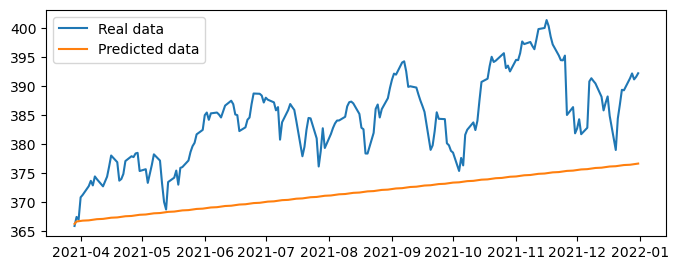

In [49]:
plt.rcParams['figure.figsize'] = (8, 3)
plt.plot(test_gdp, label = "Real data")
plt.plot(pred_gdp, label = "Predicted data")
plt.legend()
plt.show()

The auto-ARIMA seems to find somewhat decent parameters. Now, let's compare this to the ARIMA-model with parameters we find by looking at the ACF and PACF graphs.

<h3> ARIMA with ACF and PACF </h3>

<h4> Order of differencing </h4>

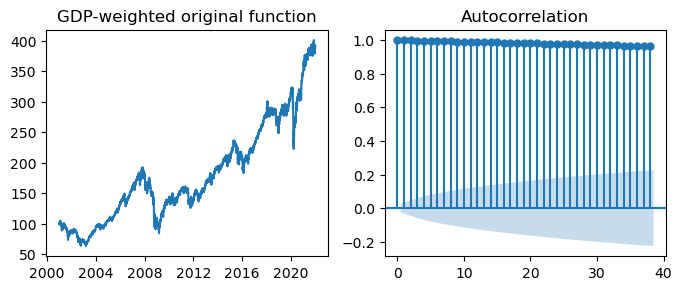

In [50]:
#original function
fig, axes = plt.subplots(1,2)
axes[0].plot(gdp); axes[0].set_title('GDP-weighted original function')
plot_acf(gdp, ax=axes[1])
plt.show()

*all values above significance line (blue area) &rarr; differencing*

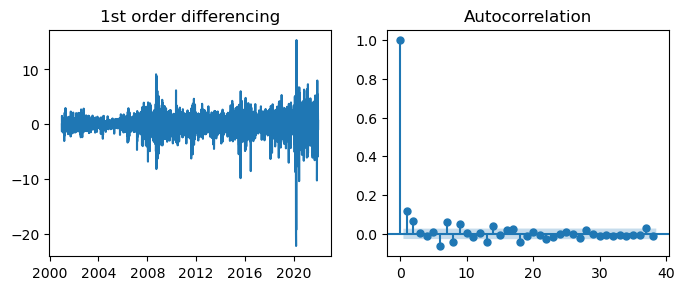

In [51]:
#1st order differencing
fig, axes = plt.subplots(1, 2)
axes[0].plot(gdp.diff()); axes[0].set_title('1st order differencing')
plot_acf(gdp.diff().dropna(), ax=axes[1])
plt.show()

*most values below significance line*

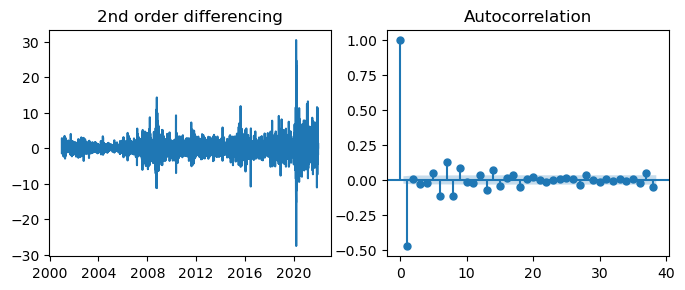

In [52]:
#2nd order differencing
fig, axes = plt.subplots(1, 2)
axes[0].plot(gdp.diff().diff()); axes[0].set_title('2nd order differencing')
plot_acf(gdp.diff().diff().dropna(), ax=axes[1])
plt.show()

*1st lag quickly into negative &rarr; overdifferenced*

<h4> AR term </h4>

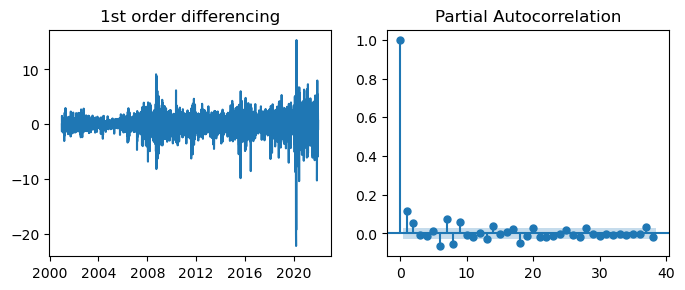

In [53]:
#partial autocorrelation function
fig, axes = plt.subplots(1, 2)
axes[0].plot(gdp.diff()); axes[0].set_title('1st order differencing')
plot_pacf(gdp.diff().dropna(), ax=axes[1])
plt.show()

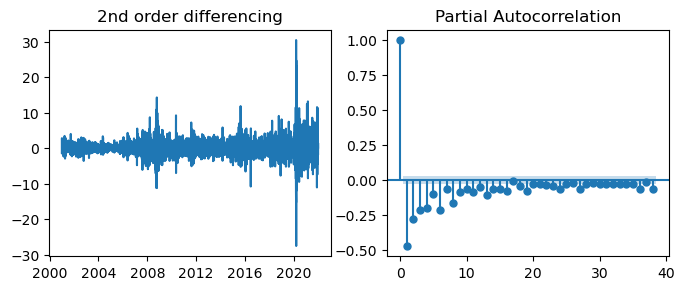

In [54]:
#partial autocorrelation function
fig, axes = plt.subplots(1, 2)
axes[0].plot(gdp.diff().diff()); axes[0].set_title('2nd order differencing')
plot_pacf(gdp.diff().diff().dropna(), ax=axes[1])
plt.show()

*Similar for cap-weighted MSCI*

<h4> MA term </h4>

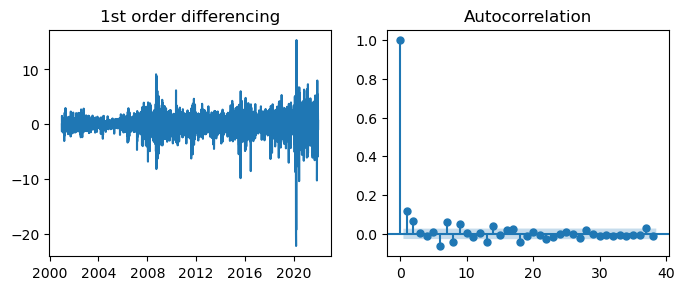

In [55]:
#1st order differencing
fig, axes = plt.subplots(1, 2)
axes[0].plot(gdp.diff()); axes[0].set_title('1st order differencing')
plot_acf(gdp.diff().dropna(), ax=axes[1])

plt.show()

In [56]:
#training on train set
model = ARIMA(train_gdp.astype(float), order = (5,2,3))
model = model.fit(disp=-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D2.MSCI ACWI GDP   No. Observations:                 5279
Model:                 ARIMA(5, 2, 3)   Log Likelihood               -9801.952
Method:                       css-mle   S.D. of innovations              1.548
Date:                Thu, 27 Jan 2022   AIC                          19623.904
Time:                        20:09:19   BIC                          19689.619
Sample:                    01-02-2001   HQIC                         19646.873
                         - 03-26-2021                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2.589e-05   1.74e-05      1.491      0.136   -8.15e-06    5.99e-05
ar.L1.D2.MSCI ACWI GDP    -1.3419      0.051    -26.076      0.000      -1.443      -1.241
ar.L2.D2.MSCI ACWI GDP    -0.4561      0.047     -9.760      0.000      -0.548      -0.365
ar.L3.D2.MSCI ACWI GDP     0.1596      0.025      6.326      0.000       0.110       0.209
ar.L4.D2.MSCI ACWI GDP     0.0390      0.024      1.627      0.104      -0.008       0.086
ar.L5.D2.MSCI ACWI GDP     0.0542      0.017      3.226      0.001       0.021       0.087
ma.L1.D2.MSCI ACWI GDP     0.4710      0.050      9.433      0.000       0.373       0.569
ma.L2.D2.MSCI ACWI GDP    -0.7787      0.028    -28.210      0.000      -0.833      -0.725
ma.L3.D2.MSCI ACWI GDP    -0.6923      0.046    -14.997      0.000      -0.783      -0.602
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9853           -0.4967j            1.1034           -0.4257
AR.2           -0.9853           +0.4967j            1.1034            0.4257
AR.3            2.2975           -0.0000j            2.2975           -0.0000
AR.4           -0.5231           -2.5145j            2.5684           -0.2826
AR.5           -0.5231           +2.5145j            2.5684            0.2826
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -1.0624           -0.5619j            1.2018           -0.4226
MA.3           -1.0624           +0.5619j            1.2018            0.4226
-----------------------------------------------------------------------------
"""

In [57]:
#predicting model on test set
start = len(train_gdp)
end = len(train_gdp) + len(test_gdp) - 1
pred_gdp = model.predict(start = start, end = end, typ = 'levels')

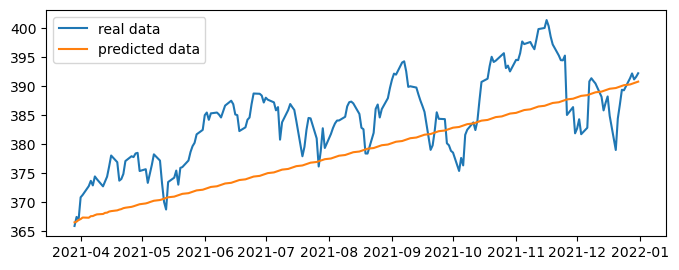

In [58]:
# out-of-time cross validation
plt.plot(test_gdp, label = "real data")
plt.plot(pred_gdp, label = "predicted data")
plt.legend()
plt.show()

(5,2,2) model seems to be better. Now we use this to predict the future.

In [59]:
# final GDP model
model = ARIMA(gdp.astype(float), order = (5,2,3))
model = model.fit(disp=-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D2.MSCI ACWI GDP   No. Observations:                 5479
Model:                 ARIMA(5, 2, 3)   Log Likelihood              -10282.139
Method:                       css-mle   S.D. of innovations              1.579
Date:                Thu, 27 Jan 2022   AIC                          20584.278
Time:                        20:10:43   BIC                          20650.365
Sample:                    01-02-2001   HQIC                         20607.334
                         - 12-31-2021                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2.688e-05   2.09e-05      1.287      0.198   -1.41e-05    6.78e-05
ar.L1.D2.MSCI ACWI GDP    -1.3576      0.051    -26.368      0.000      -1.458      -1.257
ar.L2.D2.MSCI ACWI GDP    -0.4835      0.047    -10.281      0.000      -0.576      -0.391
ar.L3.D2.MSCI ACWI GDP     0.1458      0.025      5.847      0.000       0.097       0.195
ar.L4.D2.MSCI ACWI GDP     0.0273      0.024      1.147      0.251      -0.019       0.074
ar.L5.D2.MSCI ACWI GDP     0.0443      0.016      2.693      0.007       0.012       0.077
ma.L1.D2.MSCI ACWI GDP     0.4819      0.050      9.637      0.000       0.384       0.580
ma.L2.D2.MSCI ACWI GDP    -0.7689      0.031    -24.970      0.000      -0.829      -0.709
ma.L3.D2.MSCI ACWI GDP    -0.7115      0.046    -15.449      0.000      -0.802      -0.621
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.9817           -0.5042j            1.1036           -0.4245
AR.2           -0.9817           +0.5042j            1.1036            0.4245
AR.3            2.4719           -0.0000j            2.4719           -0.0000
AR.4           -0.5628           -2.6803j            2.7387           -0.2829
AR.5           -0.5628           +2.6803j            2.7387            0.2829
MA.1            1.0004           -0.0000j            1.0004           -0.0000
MA.2           -1.0406           -0.5675j            1.1852           -0.4205
MA.3           -1.0406           +0.5675j            1.1852            0.4205
-----------------------------------------------------------------------------
"""

In [60]:
forecast_gdp = model.forecast(steps = 20)[0]
forecast_gdp

array([392.78856952, 392.77440221, 392.91725812, 393.18903756,
       393.131835  , 393.46382244, 393.42405749, 393.66338459,
       393.75709936, 393.85548651, 394.06577546, 394.09189104,
       394.32306619, 394.37496865, 394.54758455, 394.67289248,
       394.77543854, 394.95361316, 395.02865278, 395.20794561])

<h3> Maket cap weighted </h3>

In [61]:
#split data into training and testing
train_cap = cap[:-200]
test_cap = cap[-200:]

In [62]:
#training on train set
model = ARIMA(train_cap.astype(float), order = (5,2,3))
model = model.fit(disp=-1)

In [63]:
#predicting model on test set
pred_cap = model.predict(start = start, end = end, typ = 'levels')

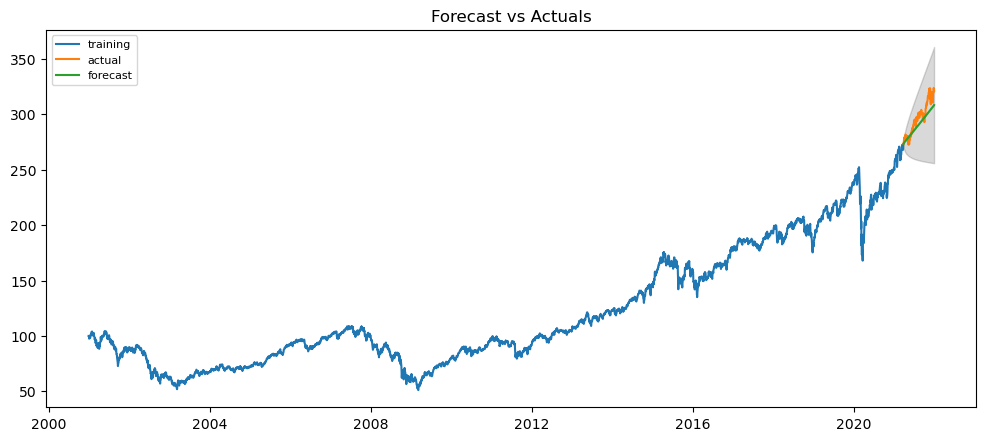

In [64]:
# Forecast
fc, se, conf = model.forecast(200, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_cap.index)
lower_series = pd.Series(conf[:, 0], index=test_cap.index)
upper_series = pd.Series(conf[:, 1], index=test_cap.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_cap, label='training')
plt.plot(test_cap, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Grey area shows us the 95% confidence interval.

In [65]:
# complete model for market cap
model = ARIMA(cap.astype(float), order = (5,2,3))
model = model.fit(disp=-1)

In [66]:
forecast_cap = model.forecast(steps = 20)[0]
forecast_cap

array([321.66577704, 321.53031394, 321.62587775, 321.94899226,
       321.73064298, 322.26494444, 322.0226131 , 322.42644417,
       322.42505775, 322.54367709, 322.81091346, 322.72807407,
       323.10005523, 323.01634357, 323.30004434, 323.36416201,
       323.47804032, 323.69788301, 323.69884386, 323.97297614])

In [67]:
forecast = pd.DataFrame({'forecast_gdp': forecast_gdp, 'forecast_cap': list(forecast_cap)}, columns=['forecast_gdp', 'forecast_cap'])
f_returns = forecast.pct_change()*100
f_cumreturns = f_returns.cumsum(axis = 0)
f_cumreturns.head()

,forecast_gdp,forecast_cap
0,NaN,NaN
1,-0.003607,-0.042113
2,0.032764,-0.012391
3,0.101934,0.088071
4,0.087385,0.020250


<AxesSubplot:xlabel='date'>

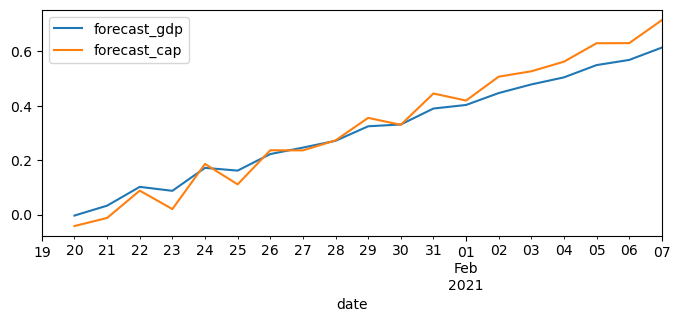

In [68]:
f_cumreturns['date'] = pd.date_range(start='19/1/2021', periods=len(f_returns), freq='D')
f_cumreturns.set_index('date', inplace=True)
f_cumreturns.plot()

<h2> GARCH </h2>

<h4> Market cap weighted </h4>

ARIMA might not be the best model in this case. Better to predict volatility with GARCH-model. Looking at the returns below, we can see some clear volatility clusters.

GARCH is ...

In [69]:
from arch import arch_model

In [70]:
returns_cap = returns['MSCI ACWI'].dropna()
returns_gdp = returns['MSCI ACWI GDP'].dropna()

Text(0.5, 1.0, 'Returns')

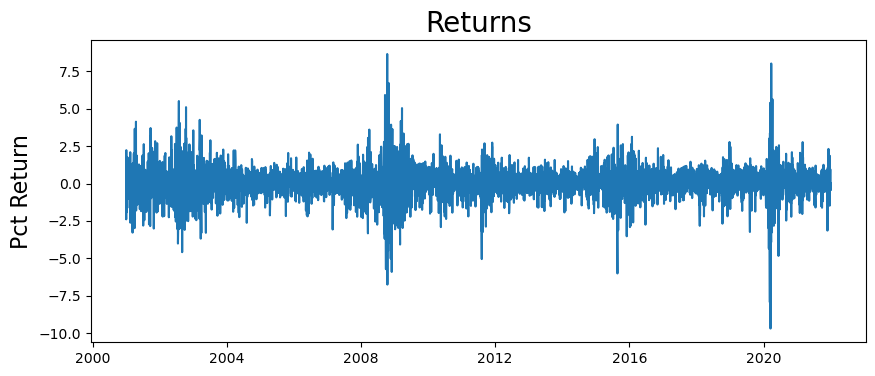

In [71]:
plt.figure(figsize=(10,4))
plt.plot(returns_cap)
plt.ylabel('Pct Return', fontsize=16)
plt.title('Returns', fontsize=20)

To determine the parameters for ou GARCH-model, we take a look at the PACF of the returns.

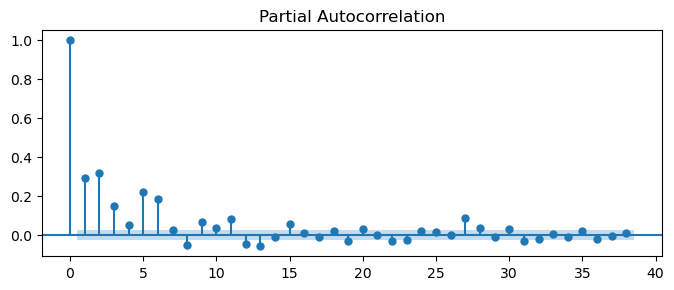

In [72]:
plot_pacf(returns_cap**2)
plt.show()

We see that the first 3 lags are clearly outside of the blue significance area. Therefore, we will try out the model setting both parameters to 3.

In [73]:
model = arch_model(returns_cap, p=3, q=3)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 156444.70640476543
Iteration:      2,   Func. Count:     24,   Neg. LLF: 20240.998424830417
Iteration:      3,   Func. Count:     38,   Neg. LLF: 9684.13236872891
Iteration:      4,   Func. Count:     49,   Neg. LLF: 10148.921147887566
Iteration:      5,   Func. Count:     60,   Neg. LLF: 7252.819786979648
Iteration:      6,   Func. Count:     71,   Neg. LLF: 6829.4245967350535
Iteration:      7,   Func. Count:     81,   Neg. LLF: 6833.461265022936
Iteration:      8,   Func. Count:     91,   Neg. LLF: 6769.038892717848
Iteration:      9,   Func. Count:    100,   Neg. LLF: 6786.373321842429
Iteration:     10,   Func. Count:    110,   Neg. LLF: 6769.305824928479
Iteration:     11,   Func. Count:    120,   Neg. LLF: 6768.405122281006
Iteration:     12,   Func. Count:    129,   Neg. LLF: 6768.355646423224
Iteration:     13,   Func. Count:    138,   Neg. LLF: 6768.346497954844
Iteration:     14,   Func. Count:    147,   Neg. LLF: 6768.34

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              MSCI ACWI   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6768.35
Distribution:                  Normal   AIC:                           13552.7
Method:            Maximum Likelihood   BIC:                           13605.6
                                        No. Observations:                 5480
Date:                Thu, Jan 27 2022   Df Residuals:                     5479
Time:                        20:17:15   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0644  1.033e-02      6.236  4.495e-10 [4.417e-02,8.466e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0395  1.830e-02      2.160  3.074e-02 [3.666e-03,7.539e-02]
alpha[1]       0.1012  2.151e-02      4.703  2.562e-06   [5.900e-02,  0.143]
alpha[2]       0.1131  4.281e-02      2.641  8.260e-03   [2.917e-02,  0.197]
alpha[3]   4.2096e-03  5.125e-02  8.214e-02      0.935  [-9.623e-02,  0.105]
beta[1]        0.0000      0.413      0.000      1.000     [ -0.809,  0.809]
beta[2]        0.5597      0.132      4.232  2.315e-05     [  0.300,  0.819]
beta[3]        0.1778      0.288      0.617      0.537     [ -0.387,  0.743]
============================================================================

Covariance estimator: robust
"""

The P-values above indicate that both the 3rd alpha and the 3rd beta are not significant. We run the model again with parameters p=2 and q=2.

In [74]:
model = arch_model(returns_cap, p=2, q=2)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 166523.21461096185
Iteration:      2,   Func. Count:     21,   Neg. LLF: 30466.310451961464
Iteration:      3,   Func. Count:     33,   Neg. LLF: 9765.73958613371
Iteration:      4,   Func. Count:     42,   Neg. LLF: 14532.948974315319
Iteration:      5,   Func. Count:     50,   Neg. LLF: 7028.812081147064
Iteration:      6,   Func. Count:     58,   Neg. LLF: 7043.960011118938
Iteration:      7,   Func. Count:     67,   Neg. LLF: 6770.351492704633
Iteration:      8,   Func. Count:     75,   Neg. LLF: 6770.651949254123
Iteration:      9,   Func. Count:     83,   Neg. LLF: 6784.120875324945
Iteration:     10,   Func. Count:     91,   Neg. LLF: 6768.987974988497
Iteration:     11,   Func. Count:     98,   Neg. LLF: 6768.9592326330185
Iteration:     12,   Func. Count:    105,   Neg. LLF: 6768.954467756365
Iteration:     13,   Func. Count:    112,   Neg. LLF: 6768.954194892733
Iteration:     14,   Func. Count:    119,   Neg. LLF: 6768.95

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:              MSCI ACWI   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6768.95
Distribution:                  Normal   AIC:                           13549.9
Method:            Maximum Likelihood   BIC:                           13589.6
                                        No. Observations:                 5480
Date:                Thu, Jan 27 2022   Df Residuals:                     5479
Time:                        20:17:18   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0640  1.036e-02      6.181  6.362e-10 [4.373e-02,8.434e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0355  8.502e-03      4.171  3.034e-05 [1.880e-02,5.212e-02]
alpha[1]       0.0930  1.788e-02      5.203  1.965e-07   [5.797e-02,  0.128]
alpha[2]       0.0999  2.262e-02      4.416  1.008e-05   [5.555e-02,  0.144]
beta[1]        0.1082      0.185      0.584      0.559     [ -0.255,  0.472]
beta[2]        0.6593      0.167      3.937  8.250e-05     [  0.331,  0.988]
============================================================================

Covariance estimator: robust
"""

In [75]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = returns_cap[:-(test_size-i)]
    model = arch_model(train, p=2, q=2)
    model_fit = model.fit(disp='off')
    pred_cap = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred_cap.variance.values[-1,:][0]))

In [76]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365:])

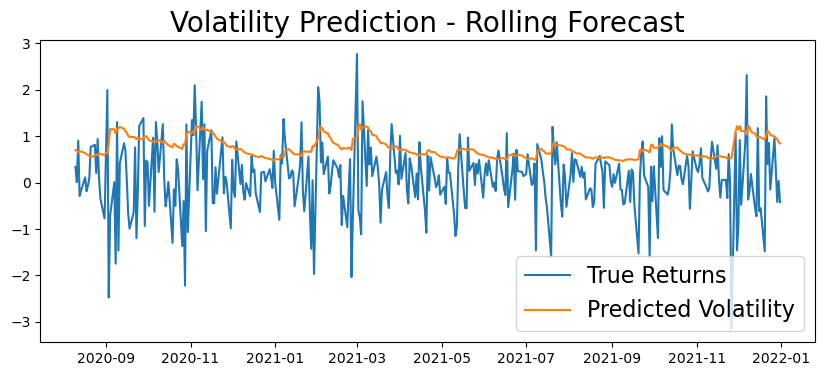

In [77]:
plt.figure(figsize=(10,4))
true, = plt.plot(returns_cap[-365:])
preds, = plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16)

The predicted volatility is a strictly positive value. If we take this into account, the trends seem to be related and our model seems to predict well. With our GARCH-model, we can predict a short period into the future.

In [78]:
pred_cap = model_fit.forecast(horizon=7)
future_dates = [returns_cap.index[-1] + timedelta(days=i) for i in range(1,8)]
pred_cap = pd.Series(np.sqrt(pred_cap.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

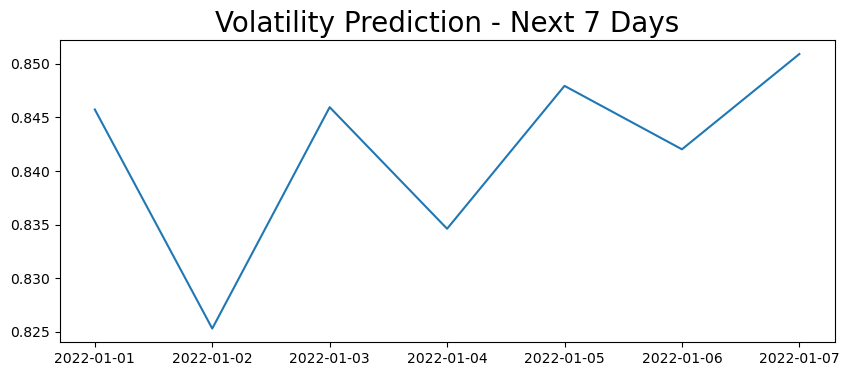

In [79]:
plt.figure(figsize=(10,4))
plt.plot(pred_cap)
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)

<h4> GDP-weighted </h4>

We use the same model for GDP-weighted ACWI. Below, we compare the results of the prediction in a plot.

In [80]:
model = arch_model(returns_gdp, p=2, q=2)
model_fit = model.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 362234.4022085608
Iteration:      2,   Func. Count:     21,   Neg. LLF: 29852.122892727242
Iteration:      3,   Func. Count:     33,   Neg. LLF: 9281.101822351324
Iteration:      4,   Func. Count:     42,   Neg. LLF: 19399.926549693577
Iteration:      5,   Func. Count:     50,   Neg. LLF: 6212.221867861682
Iteration:      6,   Func. Count:     58,   Neg. LLF: 6102.791654324363
Iteration:      7,   Func. Count:     66,   Neg. LLF: 6200.746557844128
Iteration:      8,   Func. Count:     74,   Neg. LLF: 6093.459006552066
Iteration:      9,   Func. Count:     82,   Neg. LLF: 6093.317052059312
Iteration:     10,   Func. Count:     90,   Neg. LLF: 6093.025598172886
Iteration:     11,   Func. Count:     98,   Neg. LLF: 6092.901314375205
Iteration:     12,   Func. Count:    106,   Neg. LLF: 6092.820541906439
Iteration:     13,   Func. Count:    114,   Neg. LLF: 6094.721875636369
Iteration:     14,   Func. Count:    123,   Neg. LLF: 6092.744

In [81]:
pred_gdp = model_fit.forecast(horizon=7)
future_dates = [returns_gdp.index[-1] + timedelta(days=i) for i in range(1,8)]
pred_gdp = pd.Series(np.sqrt(pred_gdp.variance.values[-1,:]), index=future_dates)

Text(0.5, 1.0, 'Volatility Prediction - Next 7 Days')

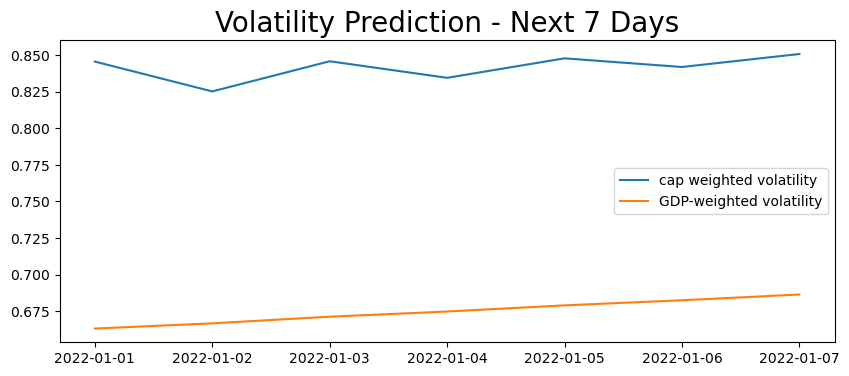

In [82]:
plt.figure(figsize=(10,4))
plt.plot(pred_cap, label = 'cap weighted volatility')
plt.plot(pred_gdp, label = 'GDP-weighted volatility')
plt.legend()
plt.title('Volatility Prediction - Next 7 Days', fontsize=20)

The graph clearly shows a higher predicted volatility for market cap weighted volatility in the near future, in comparison to GDP-weighted volatility.

<h1> Appendix: additional ARIMA validation </h1>

In [87]:
train_gdp2 = gdp[:-10]
test_gdp2 = gdp[-10:]

In [88]:
history = [tr for tr in train_gdp2]
predictions = list()

In [89]:
# walk forward validation
for t in range(len(test_gdp2)):
    model = ARIMA(history, order=(5,2,3))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_gdp2[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=384.661412, expected=378.995293
predicted=378.163933, expected=384.435717
predicted=385.123060, expected=386.802159
predicted=387.307298, expected=389.370267
predicted=389.768858, expected=389.290512
predicted=389.481445, expected=391.359582
predicted=392.061701, expected=392.193590
predicted=392.061516, expected=391.165891
predicted=391.594757, expected=391.609101
predicted=391.339199, expected=392.224353


In [92]:
# evaluate forecasts
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test_gdp2, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.896
